<a href="https://colab.research.google.com/github/zsun360/zsun360.github.io/blob/main/Q2_Separable_Filter_Updated_Min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q2 — Separable 2D Convolution ≡ Two 1D Convolutions (Concise, Updated)

**Task:** Show (mathematically or using a program) that convolving an image with a discrete, **separable** 2D kernel equals convolving with **two 1D kernels**. Estimate operation savings for an $N \times N$ image and a $(2k+1)\times(2k+1)$ kernel. Demonstrate with **Sobel**.

## 1) Short Derivation (Discrete)
If $H[u,v]=h[u]\,g[v],then(I*H)[x,y]=\sum_{u=-k}^{k}\sum_{v=-k}^{k}I[x-u,y-v]\,h[u]\,g[v] = \sum_{u=-k}^{k} h[u] \Big(\sum_{v=-k}^{k}I[x-u,y-v]\,g[v]\Big).
Let J[x,y]=\sum_{v=-k}^{k} I[x,y-v]\,g[v]. Then (I*H)[x,y] = \sum_{u=-k}^{k} h[u]\,J[x-u,y] = (J*h_{\text{row}})[x,y]$
Hence, one 2D convolution equals **two 1D convolutions** (column then row, or vice versa).

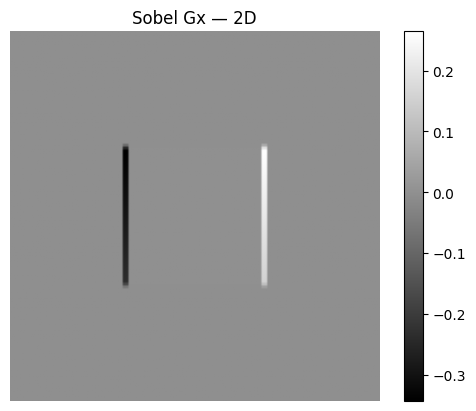

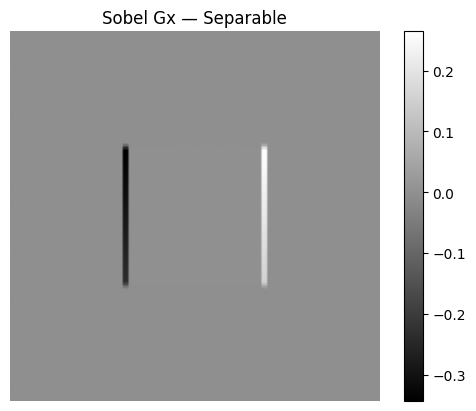

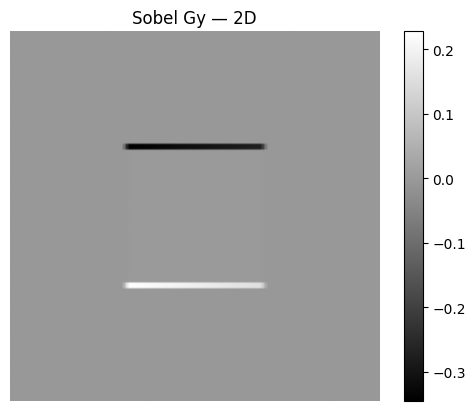

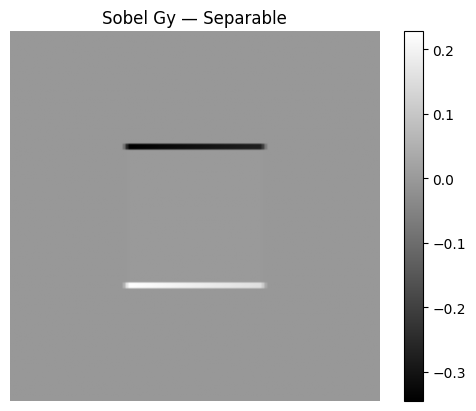

Max |difference| (Gx): 2.9802322387695312e-08
Max |difference| (Gy): 3.725290298461914e-08


In [1]:
# 2) Program: Sobel demo (separable) — 2D vs (1D+1D)
import numpy as np, matplotlib.pyplot as plt, os

# Synthetic grayscale image (self-contained)
H, W = 128, 128
y = np.linspace(0, 1, H).reshape(-1, 1)
x = np.linspace(0, 1, W).reshape(1, -1)
img = 0.6*y + 0.4*x
img[40:88, 40:88] += 0.7
img = np.clip(img, 0, 1).astype(np.float32)

d = np.array([-1, 0, 1], dtype=np.float32)
s = np.array([ 1, 2, 1], dtype=np.float32)
Gx = np.outer(s, d) / 8.0
Gy = np.outer(d, s) / 8.0

def conv2d_same(image, kernel):
    kh, kw = kernel.shape
    ph, pw = kh//2, kw//2
    kf = np.flipud(np.fliplr(kernel))
    padded = np.pad(image, ((ph, ph),(pw, pw)), mode="edge")
    out = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j] = np.sum(padded[i:i+kh, j:j+kw] * kf, dtype=np.float32)
    return out

def conv1d_horiz_same(image, ker1d):
    k = ker1d.size; p = k//2
    out = np.zeros_like(image, dtype=np.float32)
    padded = np.pad(image, ((0,0),(p,p)), mode="edge"); kf = ker1d[::-1]
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j] = np.dot(padded[i, j:j+k], kf)
    return out

def conv1d_vert_same(image, ker1d):
    k = ker1d.size; p = k//2
    out = np.zeros_like(image, dtype=np.float32)
    padded = np.pad(image, ((p,p),(0,0)), mode="edge"); kf = ker1d[::-1]
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j] = np.dot(padded[i:i+k, j], kf)
    return out

gx_2d = conv2d_same(img, Gx); gy_2d = conv2d_same(img, Gy)
gx_sep = conv1d_vert_same(conv1d_horiz_same(img, d/8.0), s)
gy_sep = conv1d_horiz_same(conv1d_vert_same(img, d/8.0), s)

OUT = "q2_outputs"; os.makedirs(OUT, exist_ok=True)
plt.imsave(f"{OUT}/input.png", img, cmap="gray", vmin=0, vmax=1)
plt.imsave(f"{OUT}/gx_2d.png", gx_2d, cmap="gray"); plt.imsave(f"{OUT}/gx_sep.png", gx_sep, cmap="gray")
plt.imsave(f"{OUT}/gy_2d.png", gy_2d, cmap="gray"); plt.imsave(f"{OUT}/gy_sep.png", gy_sep, cmap="gray")

plt.figure(); plt.imshow(gx_2d, cmap="gray"); plt.title("Sobel Gx — 2D"); plt.axis("off"); plt.colorbar(); plt.show()
plt.figure(); plt.imshow(gx_sep, cmap="gray"); plt.title("Sobel Gx — Separable"); plt.axis("off"); plt.colorbar(); plt.show()
plt.figure(); plt.imshow(gy_2d, cmap="gray"); plt.title("Sobel Gy — 2D"); plt.axis("off"); plt.colorbar(); plt.show()
plt.figure(); plt.imshow(gy_sep, cmap="gray"); plt.title("Sobel Gy — Separable"); plt.axis("off"); plt.colorbar(); plt.show()

print("Max |difference| (Gx):", float(np.max(np.abs(gx_2d - gx_sep))))
print("Max |difference| (Gy):", float(np.max(np.abs(gy_2d - gy_sep))))

## 3) Operation Savings
Per output pixel:
- **2D** $ (2k+1)^2 multiplies, (2k+1)^2-1 $ adds  
- **Separable (1D + 1D)**: $ 2(2k+1)$ multiplies, $2(2k)$ adds

For an $ N\times N$ image (ignoring borders):
- 2D: $\mathcal{O}\!\left(N^2(2k+1)^2\right)$ multiplications  
- Separable: $\mathcal{O}\!\left(2N^2(2k+1)\right)$ multiplications

**Savings factor (multiplies):** $\dfrac{(2k+1)^2}{2(2k+1)} = \dfrac{2k+1}{2}.$  
Example: \(k=3\) (7×7) ⇒ about **3.5×** fewer multiplications.

In [2]:
# Tiny numeric table
import pandas as pd
def mults_2d(N,k):  return N*N*(2*k+1)**2
def mults_sep(N,k): return 2*N*N*(2*k+1)
rows = []
for N in [128, 512, 1024]:
    for k in [1,2,3,5]:
        m2d, msep = mults_2d(N,k), mults_sep(N,k)
        rows.append({"N":N,"k":k,"2D_mults":int(m2d),"Separable_mults":int(msep),"Savings_factor":round(m2d/msep,2)})
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(rows)
df

,N,k,2D_mults,Separable_mults,Savings_factor
0,128,1,147456,98304,1.5
1,128,2,409600,163840,2.5
2,128,3,802816,229376,3.5
3,128,5,1982464,360448,5.5
4,512,1,2359296,1572864,1.5
5,512,2,6553600,2621440,2.5
6,512,3,12845056,3670016,3.5
7,512,5,31719424,5767168,5.5
8,1024,1,9437184,6291456,1.5
9,1024,2,26214400,10485760,2.5


### How to Run
1. **Run All code cell by cell**.  
